<a href="https://colab.research.google.com/github/ibonetc/Esp_IA/blob/main/IA_Busqueda_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import pydot
from IPython.display import Image, display
import queue
import numpy as np

## Clase Node, para representar los nodos del árbol de búsqueda

Esta clase, es una clase general para represetar el problema y a la vez los nodos de un árbol.

Para un problema específico se creará una clase que herede de esta.

Tiene como atributos o propiedades:
-  **state**: estado del nodo, que en dependencia del problema debe tener una representación específica
- **value**: este atributo puede servir para darle un valor(id) que identifique a cada nodo
- **children**: es un arreglo de los nodos hijos
- **parent**: El padre, o sea, el nodo que lo generó
- **operator**: El operador que lo generó
- **objective**: estado objetivo a llegar
- **level**: El nivel de profundidad del nodo, en el árbol

Como métodos se tienen:
- **add_child**: Que adiciona un hijo en la lista children, en este caso se pasan los parámetros del nodo, éste se crea y se adiciona a la lista.

- **add_node_child**: Parecido al anterior, sólo que se pasa como parámetro el nodo ya creado y sólo se adiciona a la lista children.

- **getchildrens**: Método que devuelve la lista de hijos al aplicar los operadores.

- **getState**: Método abstracto que deben implementar los problemas que hereden de Node, para definir lo que hace cada uno de los operadores. Este método devuelve el estado que se obtiene al aplicar el operador en la posición index del arreglo operators.

- **repeatStatePath**: Este método devuelve un booleano en dependencia de si el estado que se pasa está ya en el camino a la raíz. Verdadero si está, Falso sin no está. Esto es para evitar ciclos y caminos infinitos.

- **pathObjective**: Este método devuelve el camino hasta la raíz. Útil para buscar el camino cuando se encuentra el estado objetivo.

- **printPath**: Este método imprime la solución. Puede sobreescribirse en las clases que hereden de esta para imprimir la solución como se desee.

- **cost**:  Este método también debe definirse en las clases que hereden de ésta, definiendo el costo de cada operador para generar un nuevo estado.

In [101]:
class Node ():
  def __init__(self, state,value,operators,operator=None, parent=None,objective=None):
    self.state= state
    self.value = value
    self.children = []
    self.parent=parent
    self.operator=operator
    self.objective=objective
    self.level=0
    self.operators=operators

    
  def add_child(self, value, state, operator):
    node=type(self)(value=value, state=state, operator=operator,parent=self,operators=self.operators)
    node.level=node.parent.level+1
    self.children.append(node)
    return node
  
  def add_node_child(self, node):
    node.level=node.parent.level+1
    self.children.append(node)    
    return node

  #Devuelve todos los estados según los operadores aplicados
  def getchildrens(self):
    return [
        self.getState(i) 
          if not self.repeatStatePath(self.getState(i)) 
            else None for i, op in enumerate(self.operators)]
    
  def getState(self, index):
    pass
  
  def __eq__(self, other):
    return self.state == other.state
 
  def __lt__(self, other):
    return self.f() < other.f()
   
  
  def repeatStatePath(self, state):
      n=self
      while n is not None and n.state!=state:
          n=n.parent
      return n is not None
    
  def pathObjective(self):
      n=self
      result=[]
      while n is not None:
          result.append(n)
          n=n.parent
      return result
  
  def heuristic(self):
    return 0
  
  def cost(self):
    return 1
  
  def f(self): 
    return self.cost()+self.heuristic()

## Class Tree (La clase árbol)
Esta clase es la clase general de cualquier árbol, con los métodos de búsquedas y dibujo que necesite.

Debe tener la raíz del árbol y los operadores que pueda ejecutar el problema 
- **root**: Nodo raíz de tipo Node
- **operators**: Los posibles operadores a aplicar (aunque en este caso, para saber el número del operdor, es una lista con todos los operados)

In [102]:
class Tree ():
  def __init__(self, root ,operators):
    self.root=root
    self.operators=operators

  def printPath(self,n):
    stack=n.pathObjective()
    path=stack.copy()
    while len(stack)!=0:
        node=stack.pop()
        if node.operator is not None:
            print(f'operador:  {self.operators[node.operator]} \t estado: {node.state}')
        else:
            print(f' {node.state}')
    return path

  def reinitRoot(self):
    self.root.operator=None
    self.root.parent=None
    self.root.objective=None
    self.root.children = []
    self.root.level=0

  ## Primero a lo ancho
  def breadthFirst(self,endState):
    self.reinitRoot()
    pq=queue.Queue()
    pq.put(self.root)
    while not pq.empty():
      node=pq.get()
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), state=child, operator=i)
          pq.put(newChild)
          if endState==child:
            return newChild


  def dephFirst(self, endState):
    self.reinitRoot()
    pq=[]
    pq.append(self.root)    
    while len(pq)>0:
      node=pq.pop()
      if (node.parent is not None):
        node.parent.add_node_child(node)
      children=node.getchildrens()
      temp=[]
      for i,child in enumerate(children):
        if child is not None:
          newChild=type(self.root)(value=node.value+'-'+str(i),state=child,operator=i,parent=node, operators=node.operators)
          temp.append(newChild)
          if endState==child:
            node.add_node_child(newChild)
            return newChild
      #Adicionar los hijos en forma inversa para que salga primero el primero que se adicionó
      temp.reverse()
      for e in temp:
        pq.append(e)
          
  def draw(self,path):
    graph = pydot.Dot(graph_type='graph')
    nodeGraph=pydot.Node(str(self.root.state)+"-"+str(0),
                          label=str(self.root.state),shape ="circle", 
                          style="filled", fillcolor="red")
    graph.add_node(nodeGraph)
    path.pop()
    return self.drawTreeRec(self.root,nodeGraph,graph,0,path.pop(),path)
    
  def drawTreeRec(self,r,rootGraph,graph,i,topPath,path):
    if r is not None:
      children=r.children
      for j,child in enumerate(children):
        i=i+1
        color="white"
        if topPath.value==child.value:
          if len(path)>0:topPath=path.pop()
          color='red'
        c=pydot.Node(child.value,label=str(child.state)+r"\n"+r"\n"+"f="+str(child.f()), 
                      shape ="circle", style="filled", 
                      fillcolor=color)
        graph.add_node(c)
        graph.add_edge(pydot.Edge(rootGraph, c, 
                                  label=str(child.operator)+'('+str(child.cost())+')'))
        graph=self.drawTreeRec(child,c,graph,i,topPath,path)  # recursive call
      return graph
    else:
      return graph  

## Ejemplos

### Ejemplo de las jarras
Se tiene una jarra de 4L y una de 3L, las jarras no tienen medidas ni forma de medir la cantidad, sólo se puede saber la medida a la máxima capacidad.
Se cuenta con un vertedero y una llave de agua. Las jarras se pueden llenar hasta la máxima capacidad, vaciar o trasvasar de una a otra.
Se quiere obtener 2L en la jarra de 4L.

Teniendo en cuenta este problema, se puede definir el estado como:
**(cantidad jarra de 3L, cantidad jarra de 4L)**

Y los operadores como:

>0-  llenar jarra de 3 litros

>1-  llenar jarra de 4 litros

>2-  vaciar jarra de 3 litros

>3-  vaciar jarra de 4 litros

>4-  trasvasar de 3L a 4L

>5-  trasvasar de 4L a 3L


Aquí se implementa el método **getState** para definir la acción en cada operador, o sea, cuáles son los estados después de aplicar cada operador. Se devuelve el resultado para el operador en la posición index.

In [103]:
class Jarra(Node): 
  
  def getState(self, index):
    state=self.state
    nextState=None
    if index==0: 
      if state[0]<3: 
        nextState=[3,state[1]] 
      else:
        nextState=None
    elif index==1: 
      if state[1]<4: 
        nextState=[state[0],4]
      else:
        nextState=None
    elif index==2: 
      if state[0]>0: 
        nextState=[0,state[1]] 
      else:
        nextState=None
    elif index==3: 
      if state[1]>0: 
        nextState=[state[0],0] 
      else:
        nextState=None
    elif index==4: nextState=self.trasvasar3L4L(state)
    elif index==5: nextState=self.trasvasar4L3L(state)
    return nextState if state!=nextState else None

  def trasvasar4L3L(self, state):
    t=min(3-state[0],state[1])
    return [state[0]+t,state[1]-t]
  
  def trasvasar3L4L(self, state):
    t=min(state[0],4-state[1])
    return [state[0]-t,state[1]+t]
  
  #Costo acumulativo(valor 1 en cada nivel)
  def cost(self):
    return self.level
  
  def heuristic(self):
    r1=abs(objective.state[0]-self.state[0])+abs(objective.state[1]-self.state[1])
    return r1 

Se definen además las variables de:

operadores
estado inicial
estado final

In [104]:
operators=['0- llenar jarra de 3 litros','1- llenar jarra de 4 litros',
           '2- vaciar jarra de 3 litros',
           '3- vaciar jarra de 4 litros',
           '4- trasvasar de 3-4',
           '5- trasvasar de 4-3']
initState=[0,0]
endState=[0,2]

#### Primero a lo ancho

 [0, 0]
operador:  0- llenar jarra de 3 litros 	 estado: [3, 0]
operador:  4- trasvasar de 3-4 	 estado: [0, 3]
operador:  0- llenar jarra de 3 litros 	 estado: [3, 3]
operador:  4- trasvasar de 3-4 	 estado: [2, 4]
operador:  3- vaciar jarra de 4 litros 	 estado: [2, 0]
operador:  4- trasvasar de 3-4 	 estado: [0, 2]


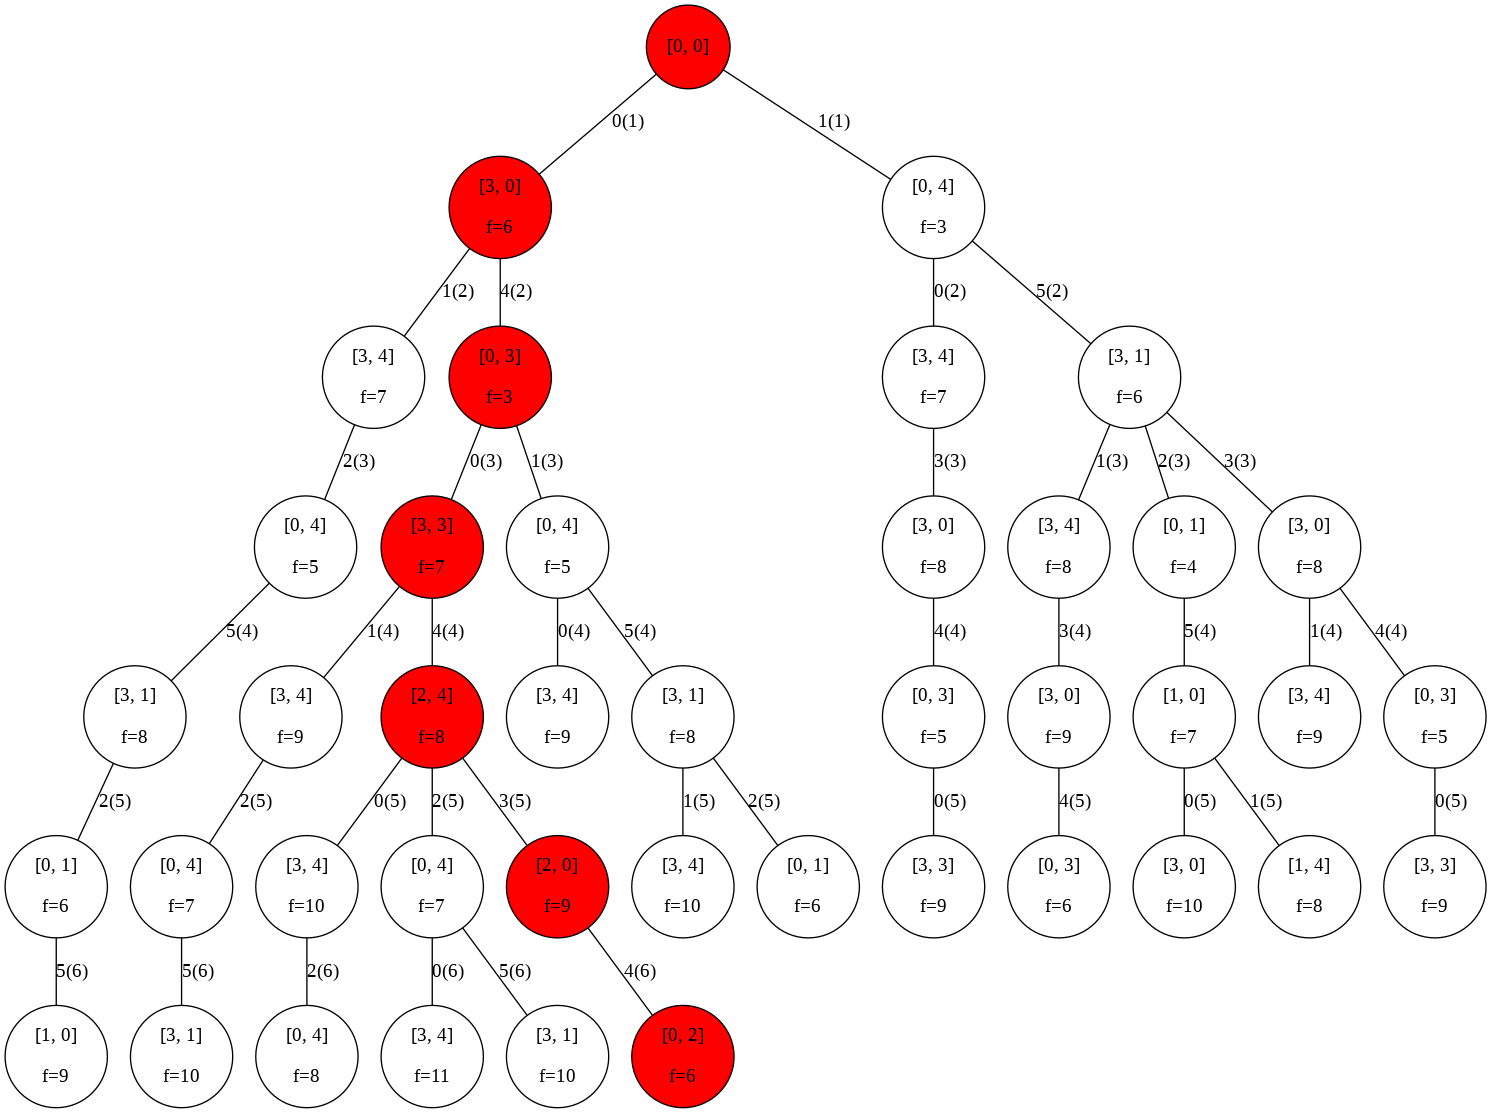

In [105]:
jarraInicio=Jarra(value="inicio",state=initState, operators=operators)
problemaJarras= Tree(jarraInicio,operators)
objective=problemaJarras.breadthFirst(endState)
path=problemaJarras.printPath(objective)
graph=problemaJarras.draw(path.copy())
tree_image = Image(graph.create_png(), width=900, height=700)
display(tree_image)

 [0, 0]
operador:  0- llenar jarra de 3 litros 	 estado: [3, 0]
operador:  1- llenar jarra de 4 litros 	 estado: [3, 4]
operador:  2- vaciar jarra de 3 litros 	 estado: [0, 4]
operador:  5- trasvasar de 4-3 	 estado: [3, 1]
operador:  2- vaciar jarra de 3 litros 	 estado: [0, 1]
operador:  5- trasvasar de 4-3 	 estado: [1, 0]
operador:  1- llenar jarra de 4 litros 	 estado: [1, 4]
operador:  5- trasvasar de 4-3 	 estado: [3, 2]
operador:  2- vaciar jarra de 3 litros 	 estado: [0, 2]


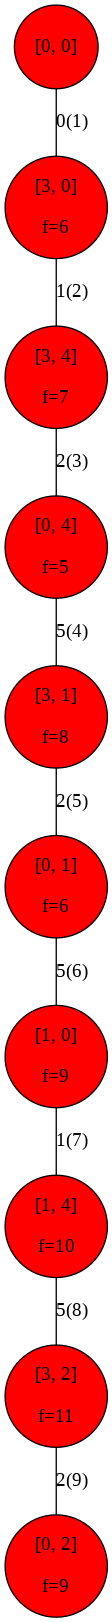

In [106]:
objective=problemaJarras.dephFirst(endState)
path=problemaJarras.printPath(objective)
graph=problemaJarras.draw(path.copy())
tree_image = Image(graph.create_png(), width=100, height=800)
display(tree_image)